In [1]:
import numpy as np 
import cv2 as cv
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# Block Matching

In [2]:
def SAD(l_pixels, r_pixels):
    if l_pixels.shape != r_pixels.shape:
        raise ValueError("Sizes must match")
    return np.sum(np.abs(l_pixels - r_pixels))

def SSD(l_pixels, r_pixels):
    if l_pixels.shape != r_pixels.shape:
        raise ValueError("Sizes must match")
    return np.sum(np.square(l_pixels - r_pixels))   

In [22]:
def block_matching(y_left, x_left, left_img, right_img, block_size = 1 , max_search_block = 200 , comp= "SAD"):
    b = block_size // 2
    left_block = left_img[y_left-b:y_left+b+1, x_left-b:x_left+b+1]
    x_min = b
    x_max = max_search_block - b
    # print(f'search bounding box: ({y_left, x_min}, ({y_left, x_max}))')
    min_diff = np.inf
    min_index = None
    best_x = 0
    for x in range(x_min, x_max):
        right_block = right_img[y_left-b:y_left+b+1, x-b:x+b+1]
        if comp =="SAD": 
            score = SAD(left_block, right_block)
        elif comp =="SSD":
            score = SSD(left_block, right_block)
        # print(f'score: {score}, {y_left, x}')
        if score < min_diff:
            min_diff = score
            min_index = (y_left, x)
            best_x = x

    return best_x

In [21]:
def draw_map(block_size, w, h, left_img, right_img, comp = "SAD"):
    disparity_map = np.zeros((h, w), dtype=np.int16)
    left_img = np.asarray(left_img, dtype = np.float32)
    right_img = np.asarray(right_img, dtype = np.float32)
    b = block_size // 2
    for y in tqdm(range(b, h-b)):
            for x in range(b, w-b):
                x_right = block_matching(y, x, left_img, right_img, block_size=block_size, 
                                        max_search_block= w, comp=comp)
                disparity_map[y, x] =  x - x_right
    return disparity_map

In [14]:
left_img = cv.imread("l3.png",cv.IMREAD_UNCHANGED)
left_img = cv.cvtColor(left_img, cv.COLOR_BGR2RGB)
right_img = cv.imread("r3.png",cv.IMREAD_UNCHANGED)
right_img = cv.cvtColor(right_img, cv.COLOR_BGR2RGB)
h , w, _ = left_img.shape

100%|██████████| 375/375 [09:29<00:00,  1.52s/it]


Text(0.5, 1.0, 'Block Matching (W = 1 using SAD)')

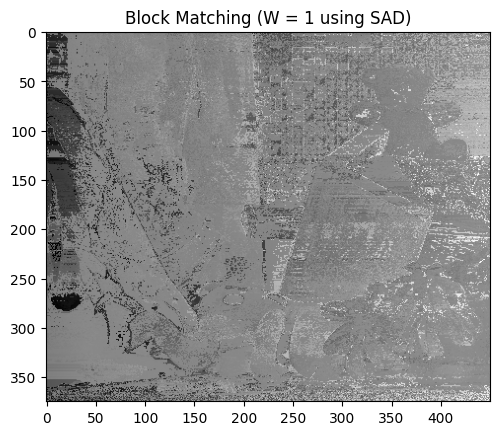

In [15]:
plt.imshow(draw_map(1, w, h, left_img, right_img, comp= "SAD"), cmap='grey')
plt.title("Block Matching (W = 1 using SAD)")

100%|██████████| 375/375 [07:26<00:00,  1.19s/it]


Text(0.5, 1.0, 'Block Matching (W = 1 using SSD)')

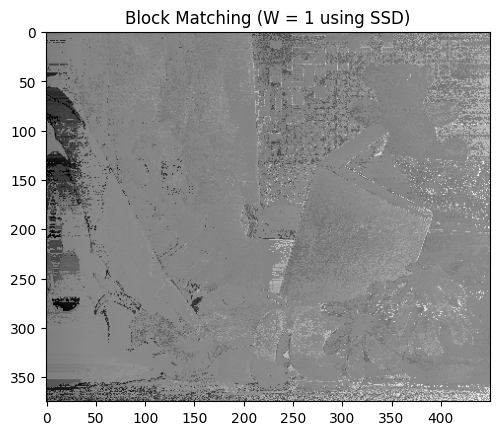

In [23]:
plt.imshow(draw_map(1, w, h, left_img, right_img, comp= "SSD"), cmap='gray')
plt.title("Block Matching (W = 1 using SSD)")

100%|██████████| 371/371 [12:55<00:00,  2.09s/it]


Text(0.5, 1.0, 'Block Matching (W = 5 using SAD)')

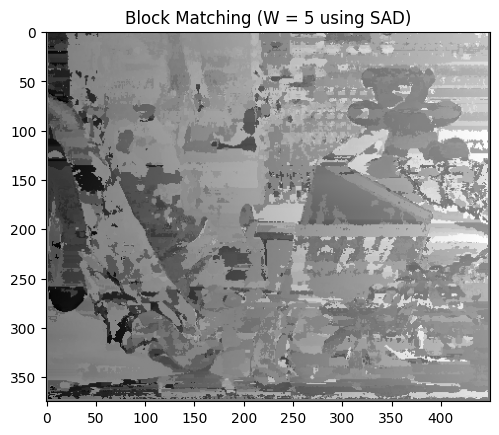

In [16]:
plt.imshow(draw_map(5, w, h, left_img, right_img, comp= "SAD"), cmap='gray')
plt.title("Block Matching (W = 5 using SAD)")

100%|██████████| 371/371 [08:58<00:00,  1.45s/it]


Text(0.5, 1.0, 'Block Matching (W = 5 using SSD)')

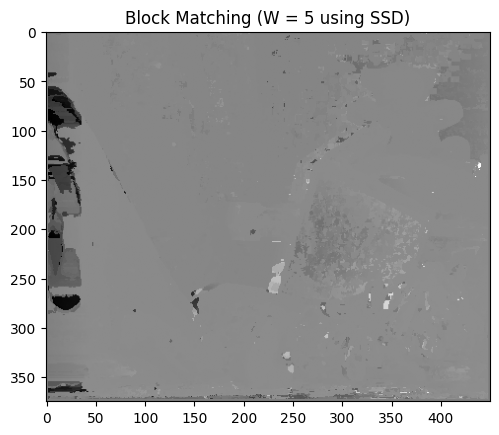

In [24]:
plt.imshow(draw_map(5, w, h, left_img, right_img, comp= "SSD"), cmap='gray')
plt.title("Block Matching (W = 5 using SSD)")

100%|██████████| 367/367 [13:47<00:00,  2.25s/it]


Text(0.5, 1.0, 'Block Matching (W = 9 using SAD)')

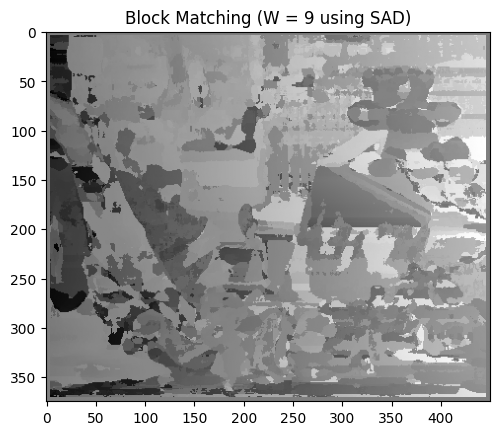

In [17]:
plt.imshow(draw_map(9, w, h, left_img, right_img, comp= "SAD"), cmap='gray')
plt.title("Block Matching (W = 9 using SAD)")

100%|██████████| 367/367 [08:59<00:00,  1.47s/it]


Text(0.5, 1.0, 'Block Matching (W = 9 using SSD)')

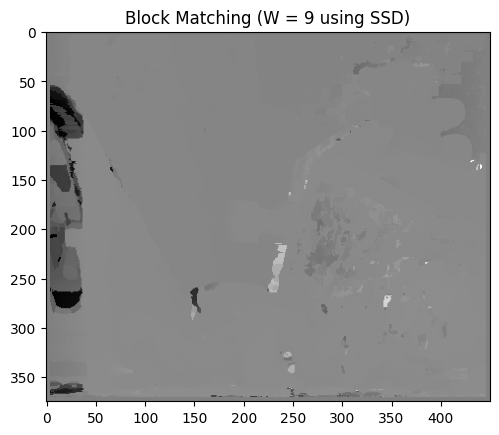

In [25]:
plt.imshow(draw_map(9, w, h, left_img, right_img, comp= "SSD"), cmap='gray')
plt.title("Block Matching (W = 9 using SSD)")

# Dynamic Programming

In [18]:
def compute_DP(left_scanline,right_scanline,sigma,c0):

  left_scanline = left_scanline.astype(np.float32)
  right_scanline = right_scanline.astype(np.float32)

  N=len(left_scanline)
  D=np.zeros((N,N))
  
  for i in range(1,N):
    D[0,i] = c0*i
    D[i,0] = c0*i


  for i in range(1, N):
      for j in range(1, N):
        dij = ((left_scanline[i] - right_scanline[j]) ** 2) / (sigma ** 2)

        D[i][j] = min((D[i - 1][j -1] + dij), (D[i - 1][j] + c0), (D[i][j - 1] + c0))


  disparty_shift = np.zeros(N)

  i, j = N-1,N-1
  while i>0 and j>0:
    if D[i,j]== D[i-1,j-1] + ((left_scanline[i] - right_scanline[j]) ** 2) / (sigma ** 2):
      disparty_shift[i] = np.abs(j-i)
      i-=1
      j-=1

    elif D[i,j]==D[i-1,j]+c0:
      disparty_shift[i] = 0
      i-=1

    elif D[i,j]==D[i,j-1]+c0:
      j-=1


  return D,disparty_shift

def img_disparity(imgL, imgR):
  imgL = np.asarray(imgL, dtype = np.float32)
  imgR = np.asarray(imgR, dtype = np.float32)

  disparty_map = np.zeros(imgL.shape)

  for row in range(imgL.shape[0]):
    row_D,disparty_shift = compute_DP(imgL[row, :], imgR[row, :], 2, 1)
    disparty_map[row] = disparty_shift

  plt.imshow(disparty_map, cmap='gray')
  # print(f"\n===== ROW {row} DP MATRIX (D) =====")
  # print(row_D)
  # print(f"Disparity vector for row {row}:")
  # print(disparty_shift)


  return disparty_map

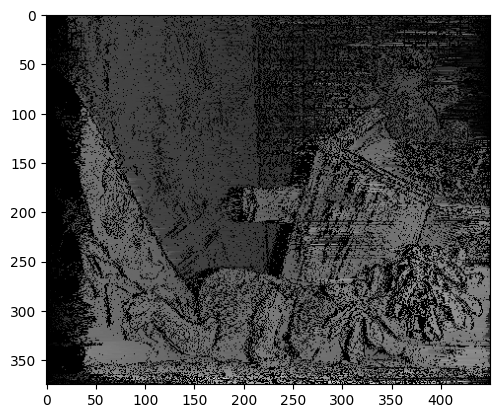

In [19]:
l1 = cv.cvtColor(left_img, cv.COLOR_RGB2GRAY)
r1 = cv.cvtColor(right_img, cv.COLOR_RGB2GRAY)
d_map = img_disparity(l1, r1)

# Plotting

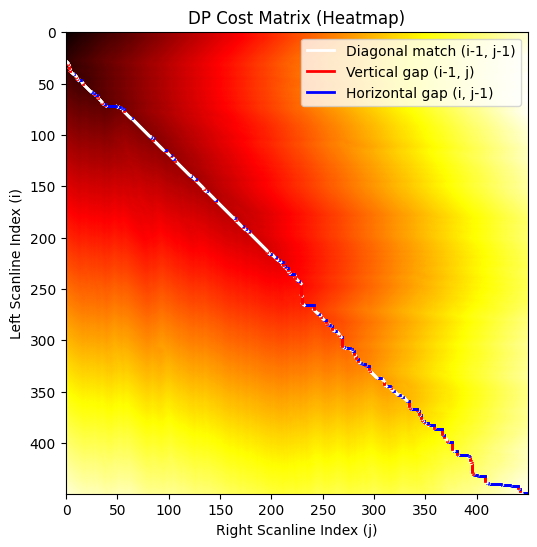

In [20]:
def draw_output(imgL, imgR, sigma, c0):
    imgL = np.asarray(imgL, dtype=np.float32)
    imgR = np.asarray(imgR, dtype=np.float32)

    # pick a row
    row = 150
    left = imgL[row, :]
    right = imgR[row, :]
    N = len(left)

    # compute DP
    D, _ = compute_DP(left, right, sigma, c0)

    # Plot heatmap
    plt.figure(figsize=(8,6))
    plt.imshow(D, cmap='hot', interpolation='nearest')
    plt.title("DP Cost Matrix (Heatmap)")
    plt.xlabel("Right Scanline Index (j)")
    plt.ylabel("Left Scanline Index (i)")
    
    # --- Legend handles ---
    diag_handle, = plt.plot([], [], 'w-', linewidth=2, label='Diagonal match (i-1, j-1)')
    vert_handle, = plt.plot([], [], 'r-', linewidth=2, label='Vertical gap (i-1, j)')
    horiz_handle, = plt.plot([], [], 'b-', linewidth=2, label='Horizontal gap (i, j-1)')

    # Backtracking path overlay
    i, j = N-1, N-1

    while i > 0 and j > 0:
        dij = ((left[i] - right[j]) ** 2) / (sigma ** 2)

        if D[i, j] == D[i-1, j-1] + dij:
            plt.plot([j, j-1], [i, i-1], 'w-', linewidth=2)  # diagonal move
            i -= 1
            j -= 1
        elif D[i, j] == D[i-1, j] + c0:
            plt.plot([j, j], [i, i-1], 'r-', linewidth=2)  # vertical move
            i -= 1
        else:
            plt.plot([j, j-1], [i, i], 'b-', linewidth=2)  # horizontal move
            j -= 1
    # Show legend
    plt.legend(loc='upper right')
    plt.show()

draw_output(l1, r1, 2, 1)
